## CSE 4705 Project: Generate Explanations

Tom McCarthy & Filip Graham

Imports

In [1]:
import pandas as pd
import shap
import statsmodels.formula.api as sm
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\tomkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load data

In [2]:
raw_data = pd.read_csv("cse4705_summary_data.csv")
counties = {"Andover":"Tolland","Ansonia":"New Haven","Ashford":"Windham","Avon":"Hartford","Barkhamsted":"Litchfield","Beacon Falls":"New Haven","Berlin":"Hartford","Bethany":"New Haven","Bethel":"Fairfield","Bethlehem":"Litchfield","Bloomfield":"Hartford","Bolton":"Tolland","Bozrah":"New London","Branford":"New Haven","Bridgeport":"Fairfield","Bridgewater":"Litchfield","Bristol":"Hartford","Brookfield":"Fairfield","Brooklyn":"Windham","Burlington":"Hartford","Canaan":"Litchfield","Canterbury":"Windham","Canton":"Hartford","Chaplin":"Windham","Cheshire":"New Haven","Chester":"Middlesex","Clinton":"Middlesex","Colchester":"New London","Colebrook":"Litchfield","Columbia":"Tolland","Cornwall":"Litchfield","Coventry":"Tolland","Cromwell":"Middlesex","Danbury":"Fairfield","Darien":"Fairfield","Deep River":"Middlesex","Derby":"New Haven","Durham":"Middlesex","East Granby":"Hartford","East Haddam":"Middlesex","East Hampton":"Middlesex","East Hartford":"Hartford","East Haven":"New Haven","East Lyme":"New London","East Windsor":"Hartford","Eastford":"Windham","Easton":"Fairfield","Ellington":"Tolland","Enfield":"Hartford","Essex":"Middlesex","Fairfield":"Fairfield","Farmington":"Hartford","Franklin":"New London","Glastonbury":"Hartford","Goshen":"Litchfield","Granby":"Hartford","Greenwich":"Fairfield","Griswold":"New London","Groton":"New London","Guilford":"New Haven","Haddam":"Middlesex","Hamden":"New Haven","Hampton":"Windham","Hartford":"Hartford","Hartland":"Hartford","Harwinton":"Litchfield","Hebron":"Tolland","Kent":"Litchfield","Killingly":"Windham","Killingworth":"Middlesex","Lebanon":"New London","Ledyard":"New London","Lisbon":"New London","Litchfield":"Litchfield","Lyme":"New London","Madison":"New Haven","Manchester":"Hartford","Mansfield":"Tolland","Marlborough":"Hartford","Meriden":"New Haven","Middlebury":"New Haven","Middlefield":"Middlesex","Middletown":"Middlesex","Milford":"New Haven","Monroe":"Fairfield","Montville":"New London","Morris":"Litchfield","Naugatuck":"New Haven","New Britain":"Hartford","New Canaan":"Fairfield","New Fairfield":"Fairfield","New Hartford":"Litchfield","New Haven":"New Haven","New London":"New London","New Milford":"Litchfield","Newington":"Hartford","Newtown":"Fairfield","Norfolk":"Litchfield","North Branford":"New Haven","North Canaan":"Litchfield","North Haven":"New Haven","North Stonington":"New London","Norwalk":"Fairfield","Norwich":"New London","Old Lyme":"New London","Old Saybrook":"Middlesex","Orange":"New Haven","Oxford":"New Haven","Plainfield":"Windham","Plainville":"Hartford","Plymouth":"Litchfield","Pomfret":"Windham","Portland":"Middlesex","Preston":"New London","Prospect":"New Haven","Putnam":"Windham","Redding":"Fairfield","Ridgefield":"Fairfield","Rocky Hill":"Hartford","Roxbury":"Litchfield","Salem":"New London","Salisbury":"Litchfield","Scotland":"Windham","Seymour":"New Haven","Sharon":"Litchfield","Shelton":"Fairfield","Sherman":"Fairfield","Simsbury":"Hartford","Somers":"Tolland","South Windsor":"Hartford","Southbury":"New Haven","Southington":"Hartford","Sprague":"New London","Stafford":"Tolland","Stamford":"Fairfield","Sterling":"Windham","Stonington":"New London","Stratford":"Fairfield","Suffield":"Hartford","Thomaston":"Litchfield","Thompson":"Windham","Tolland":"Tolland","Torrington":"Litchfield","Trumbull":"Fairfield","Union":"Tolland","Vernon":"Tolland","Voluntown":"New London","Wallingford":"New Haven","Warren":"Litchfield","Washington":"Litchfield","Waterbury":"New Haven","Waterford":"New London","Watertown":"Litchfield","West Hartford":"Hartford","West Haven":"New Haven","Westbrook":"Middlesex","Weston":"Fairfield","Westport":"Fairfield","Wethersfield":"Hartford","Willington":"Tolland","Wilton":"Fairfield","Winchester":"Litchfield","Windham":"Windham","Windsor":"Hartford","Windsor Locks":"Hartford","Wolcott":"New Haven","Woodbridge":"New Haven","Woodbury":"Litchfield","Woodstock":"Windham"}
raw_data['county'] = raw_data['town'].map(counties)
print(raw_data.shape)

(812, 63)


## Random Forest: Feature Importance using scikit learn

We re-create the same Random Forest classifier in our Supervised Learning deliverable, and use the built-in feature_importances property, as described [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

In [3]:
feature_names = ['count', 'avg_sale_price', 'sales_ratio_q1', 'FYE_total_net_grand_list', 'Grand_list_personal_property', 'Grand_list_apartment', 'Grand_list_commercial', 'Grand_list_industrial', 'Grand_list_land_use', 'Mill_rate_motor_vehicle', 'Net_current_education_expenditures_CSDE']

cl_inp_df = raw_data[feature_names]
cl_res_df = raw_data[['county']]

cl_inp_train, cl_inp_test, cl_res_train, cl_res_test = train_test_split(cl_inp_df, cl_res_df, test_size=0.2, random_state=42)
scaler = StandardScaler()
cl_inp_train = scaler.fit_transform(cl_inp_train)
cl_inp_test = scaler.transform(cl_inp_test)

In [4]:
classifier = RandomForestClassifier(n_estimators=500, random_state=42)
classifier.fit(cl_inp_train, cl_res_train)

RandomForestClassifier(n_estimators=500, random_state=42)

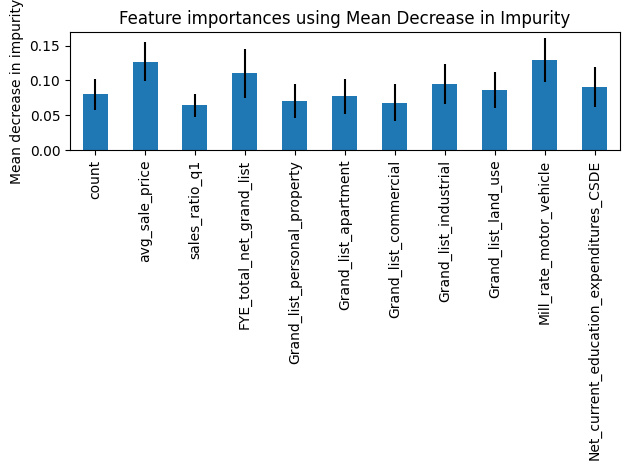

In [10]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We see that the most "important" features according to the decrease in impurity is average sale price, total net grand list, and mill rate of motor vehicles. Let's see what these features look like for each county.

In [12]:
df_imp_features = raw_data[['county', 'avg_sale_price', 'FYE_total_net_grand_list', 'Mill_rate_motor_vehicle']]
df_imp_features.groupby(["county"])[['avg_sale_price', 'FYE_total_net_grand_list', 'Mill_rate_motor_vehicle']].median()

,avg_sale_price,FYE_total_net_grand_list,Mill_rate_motor_vehicle
county,,,
Fairfield,577321.517241,4.686815e+09,28.390
Hartford,284348.940299,2.475265e+09,34.100
Litchfield,358524.321429,5.887249e+08,27.510
Middlesex,328805.256604,9.541372e+08,30.330
New Haven,302944.395349,2.099362e+09,32.740
New London,282032.631826,7.310666e+08,28.140
Tolland,275562.160342,7.982575e+08,31.805
Windham,248673.265306,3.793886e+08,26.420


We see that Fairfield County stands out with a high average sale price nearly twice as high as other counties. Other counties also have distinct characteristics explained by these features

- Hartford County has a high motor vehicle mill rate
- Windham County has the lowest values across all three features
- Litchfield County has the second highest sale price for residential homes, but a relatively low grand list, possibly because there are fewer large properties like apartments/industrial/commercial buildings.

#### Impurity-based feature importance vs. Permutation feature importance

Scikit learn's guide describes that impurity-based feature importance can be misleading for high cardinality features (many unique values). In our dataset, all of the values are numerical instead of categorical, so this likely isn't relevant. Regardless, let's try using the permutation measure as well.

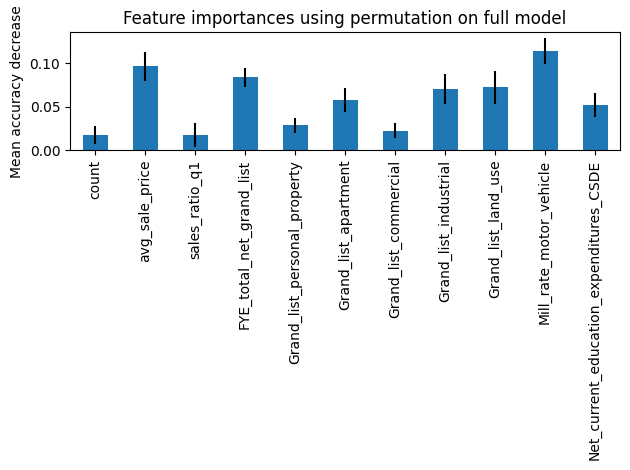

In [15]:
result = permutation_importance(
    classifier, cl_inp_test, cl_res_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

The three most important features are consistent, but the permutation importance separates the rest of the features into distinct moderately important and less important groups.

## SHAP Analysis

Imports and Load Data

In [2]:
df = pd.read_csv('cse4705_summary_data.csv')

In [ ]:
# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(classifier)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(cl_inp_test)



In [25]:
print(classifier.classes_)

['Fairfield' 'Hartford' 'Litchfield' 'Middlesex' 'New Haven' 'New London'
 'Tolland' 'Windham']


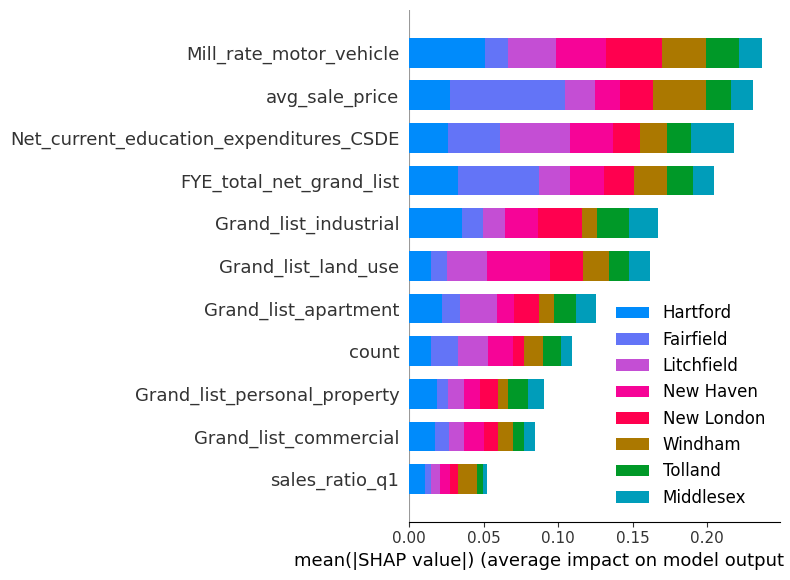

In [27]:
shap.summary_plot(shap_values, cl_inp_test, plot_type="bar", feature_names=feature_names, class_names=classifier.classes_)

In [20]:
preds = classifier.predict(cl_inp_test)

shap_values_for_preds = np.array([shap_values[class_idx][i][:] for i, class_idx in enumerate(preds)])

shap.summary_plot(shap_values_for_preds, cl_inp_test)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [9]:
print(shap_values.shape)
print(cl_inp_test.shape)

(163, 11, 8)
(163, 11)


Clean Data

Preprocess

Train Model and SHAP Analysis on Random Forest Model

## OLS: Using statsmodels

Unlike the classifier, our OLS model used only one independent feature to predict a dependent feature, so we focus on summary statistics to identify how "important" that one feature was.

In [16]:
reg_inp_df = raw_data[['median_sale_price', 'Per_capita_income_ACS']].dropna()
reg_res_df = reg_inp_df[['median_sale_price']]

reg_inp_train, reg_inp_test, reg_res_train, reg_res_test = train_test_split(reg_inp_df, reg_res_df, test_size=0.2, random_state=42)

# # print(reg_inp_train)

regression = sm.ols(formula="median_sale_price ~ Per_capita_income_ACS", data=reg_inp_train).fit()
reg_res_pred = regression.predict(reg_inp_test)

rmse = np.sqrt(mean_squared_error(reg_res_test, reg_res_pred))
mae = mean_absolute_error(reg_res_test, reg_res_pred)

print(rmse, mae)

print(regression.summary())

128888.47367953949 77828.83801496544
                            OLS Regression Results                            
Dep. Variable:      median_sale_price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     1774.
Date:                Sun, 20 Apr 2025   Prob (F-statistic):          1.87e-172
Time:                        13:44:32   Log-Likelihood:                -6971.5
No. Observations:                 540   AIC:                         1.395e+04
Df Residuals:                     538   BIC:                         1.396e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

R-squared is 0.767, indicating a strong relationship between per capita income and median sale price. Additionally, the probability of F-statistic, which measures the probability that the effect of the input features is 0, is negligible, indicating that the per capita income has a statistically significant effect on sale price. We also see that the P>|t| measure, which describes how likely the coefficient is measured through our model by chance, is 0. Although there were a few significant outliers as visualized in the Supervised Learning deliverable, there is still a very strong relationship between the two features.